In [1]:
import os
import copy
import pandas as pd
import json
from pathlib import Path
import logging
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset


def get_labels(args):
    intents = [label.strip() for label in open(os.path.join(args.data_dir, args.intent_label_file), 'r', encoding='utf-8')]
    slots = [label.strip() for label in open(os.path.join(args.data_dir, args.slot_label_file), 'r', encoding='utf-8')]
    return intents.extend(slots)




/home/crossing/miniconda3/envs/jointbert/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
in_path = "./Dataset/dataset_seq_in.txt"

with open(in_path, encoding='utf-8') as f:
    seq_in = [line.rstrip() for line in f if line != '\n' ]


out_path = "./Dataset/dataset_seq_out.txt"

with open(out_path, encoding='utf-8') as f:
    seq_out = [line.rstrip() for line in f if line != '\n']


def rem_say(seq_in,seq_out,remove = True):
    if remove:
        say_idx = [i for i,labels in enumerate(seq_out) if 'B_say' in labels]
        seq_in = [seq for i,seq in enumerate(seq_in) if i not in  say_idx]
        seq_out = [seq for i,seq in enumerate(seq_out) if i not in  say_idx]
    return seq_in, seq_out

seq_in, seq_out = rem_say(seq_in,seq_out,remove = True)

<AxesSubplot: xlabel='0'>

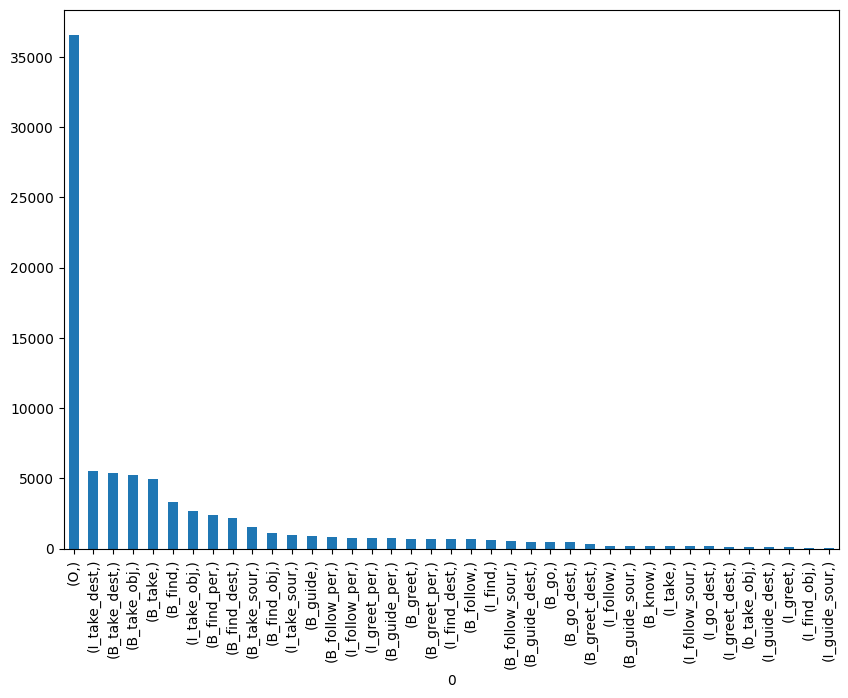

In [3]:
label_df = pd.DataFrame( x for seq in seq_out for x in seq.split())
# display(label_df.head(5))
label_df.value_counts(subset=None, dropna = True).plot(kind = 'bar', figsize = (10,7))

In [4]:
def get_labels_dict(seq_out):
    labels = [line.strip().split() for line in seq_out]
    label_df = pd.Series( x for seq in labels for x in seq)
    lst = label_df.unique().tolist()
    return {label:i for i,label in enumerate(lst)}

label_dict = get_labels_dict(seq_out)
label_dict

{'B_find': 0,
 'O': 1,
 'B_find_obj': 2,
 'B_find_dest': 3,
 'B_find_per': 4,
 'I_find_dest': 5,
 'B_guide': 6,
 'B_guide_per': 7,
 'B_guide_dest': 8,
 'B_take': 9,
 'I_take': 10,
 'B_take_obj': 11,
 'B_take_sour': 12,
 'I_take_sour': 13,
 'B_follow': 14,
 'B_follow_per': 15,
 'B_take_dest': 16,
 'I_take_dest': 17,
 'B_greet': 18,
 'I_greet': 19,
 'B_greet_per': 20,
 'I_greet_per': 21,
 'B_greet_dest': 22,
 'I_greet_dest': 23,
 'I_follow': 24,
 'I_take_obj': 25,
 'I_find': 26,
 'B_follow_sour': 27,
 'B_know': 28,
 'I_follow_per': 29,
 'I_guide_dest': 30,
 'I_follow_sour': 31,
 'B_go': 32,
 'B_go_dest': 33,
 'B_guide_sour': 34,
 'I_go_dest': 35,
 'I_find_obj': 36,
 'I_guide_sour': 37,
 'b_take_obj': 38}

In [5]:
# # !pip install deep_utils
# from deep_utils import stratify_train_test_split_multi_label
# from typing import Union
# from deep_utils.utils.algorithm_utils.main import subset_sum
# import numpy as np
# def stratify_train_test_split_multi_label(x: Union[list, tuple, np.ndarray], y: np.ndarray, test_size=0.2,
#                                           closest_ratio=False):
#     """
#         A handy function for splitting multi-label samples based on their number of classes. This is mainly useful for
#     object detection and ner-like tasks that each sample may contain several objects/tags from different classes! The
#     process of splitting starts from classes with the smallest number of samples to make sure their ratio is saved
#     because they have small numbers of samples, retaining the ratio for them is challenging compared to those classes
#     with more samples
#     :param x: A list, Tuple or ndarray that contains the samples
#     :param y: A 2D array that represents the number of labels in each class. Each column is representative of a class.
#     As an example: y = np.array([[2, 3], [1, 1]]) says that sample one has
#     two objects/tags for class 0 and 3 objects/tags for class 1 and so on
#     :param test_size: size of the test set
#     :param closest_ratio: For huge arrays extracting the closest ratio requires an intensive recursive function to work
#      which could result in maximum recursion error. Being set to True will choose samples from the those with the smallest difference to the target number to ensure the best ratio. Set this variable to True if you are sure. by default is set to False.
#     :return:
#     >>> y = np.array([[1, 2, 0], [1, 0, 0], [1, 2, 0]])
#     >>> x = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
#     >>> stratify_train_test_split_multi_label(x, y, test_size=0.3)
#     (array([[2, 2, 2],
#            [3, 3, 3]]), array([[1, 1, 1]]), array([[1, 0, 0],
#            [1, 2, 0]]), array([[1, 2, 0]]))
#     >>> x = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
#     >>> y = np.array([[0, 0], [0, 0], [0, 1], [0, 1], [1, 1], [1, 1], [1, 0], [1, 0]])
#     >>> x_train, x_test, y_train, y_test = stratify_train_test_split_multi_label(x, y, test_size=0.5, closest_ratio=False)
#     >>> x_train
#     array([[1, 2],
#            [3, 4],
#            [1, 2],
#            [3, 4]])
#     >>> x_test
#     array([[1, 2],
#            [3, 4],
#            [1, 2],
#            [3, 4]])
#     >>> y_train
#     array([[0, 1],
#            [0, 1],
#            [1, 0],
#            [1, 0]])
#     >>> y_test
#     array([[1, 1],
#            [1, 1],
#            [0, 0],
#            [0, 0]])
#     >>> print("class ratio:", tuple(y_test.sum(0) / y.sum(0)))
#     class ratio: (0.5, 0.5)
#     >>> print("sample ratio:", y_test.shape[0] / y.shape[0])
#     sample ratio: 0.5
#     """
#     assert len(y.shape) == 2, "y should be 2D"
#     assert test_size > 0.0, "test_size cannot be a zero or negative value!"
#     x = np.array(x, dtype=np.object_) if not isinstance(x, np.ndarray) else x

#     # excluding samples with no objects/tags
#     non_objects = np.any(y.sum(1) == 0)
#     if non_objects:
#         y_no_objects = y[y.sum(1) == 0]
#         x_no_objects = x[y.sum(1) == 0]
#         x = x[y.sum(1) > 0]
#         y = y[y.sum(1) > 0]

#     available_samples = np.ones((y.shape[0]), dtype=np.bool8)
#     test_samples = np.zeros((y.shape[0]), dtype=np.bool8)
#     train_samples = np.zeros((y.shape[0]), dtype=np.bool8)
#     class_sample_counts = y.sum(axis=0)
#     ideal_train_size = np.floor(sum(class_sample_counts) * (1 - test_size))

#     # stratify starts from a class with the lowest number of samples
#     class_indices = np.argsort(class_sample_counts)
#     for class_index in class_indices:
#         test_number_samples = y[:, class_index][test_samples].sum()
#         n_test = np.ceil(class_sample_counts[class_index] * test_size)
#         n_test = max(0, n_test - test_number_samples)
#         input_labels = y[:, class_index].copy()
#         input_labels[np.invert(available_samples)] = 0
#         if n_test == 0 or len(input_labels) == 0:
#             continue
#         if closest_ratio:
#             chosen_indices, *_ = subset_sum(input_numbers=input_labels, target_number=n_test)
#         else:
#             sorted_indices = np.argsort(input_labels)
#             cum_sum_values = np.cumsum(input_labels[sorted_indices])
#             chosen_indices = sorted_indices[cum_sum_values < n_test].tolist()
#             if len(chosen_indices) < len(sorted_indices):
#                 chosen_indices.append(sorted_indices[len(chosen_indices)])
#         # Update available_samples, train_samples, test_samples
#         for update_index, n_label in enumerate(input_labels):
#             if n_label == 0:
#                 # samples that have no elements are ignored ...
#                 continue
#             if update_index in chosen_indices:
#                 test_samples[update_index] = True
#                 train_samples[update_index] = False
#             else:
#                 test_samples[update_index] = False
#                 train_samples[update_index] = True
#             available_samples[update_index] = False
#     # Allocating all the remaining samples to train because the code structure ensures the ratio of test
#     # samples to the whole dataset.
#     train_samples = np.bitwise_or(train_samples, np.bitwise_not(test_samples))

#     if non_objects:
#         # splitting samples with no objects trying to save the balance between train and test numbers

#         train_left = int(ideal_train_size - sum(train_samples))
#         indices = np.arange(len(y_no_objects))
#         np.random.shuffle(indices)

#         x_no_objects_train, y_no_objects_train = x_no_objects[:train_left], y_no_objects[:train_left]
#         x_no_objects_test, y_no_objects_test = x_no_objects[train_left:], y_no_objects[train_left:]

#         return np.concatenate([x[train_samples], x_no_objects_train]), \
#                np.concatenate([x[test_samples], x_no_objects_test]), \
#                np.concatenate([y[train_samples], y_no_objects_train]), \
#                np.concatenate([y[test_samples], y_no_objects_test])
#     else:
#         return x[train_samples], x[test_samples], y[train_samples], y[test_samples]
    
    
    
# # x = seq_in.copy()
# # y = [[label_dict[label] for label in line.split()] for line in seq_out]

# # # X_train,X_test, Y_train, Y_test = stratify_train_test_split_multi_label(x, y, test_size=0.2, closest_ratio=False)
# # y

In [6]:
from sklearn.model_selection import train_test_split


# split the train out of the rest
X_train, X_val_test, Y_train, Y_val_test = train_test_split(seq_in, seq_out, test_size=0.25, random_state=42)

#split the val and test
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.8, random_state=42)

print(f'X_train len: {len(X_train)}')
print(f'Y_train len: {len(Y_train)}\n')

print(f'X_val len: {len(X_val)}')
print(f'Y_val len: {len(Y_val)}\n')

print(f'X_test len: {len(X_test)}')
print(f'Y_test len: {len(Y_test)}\n')


# Write seq files for envs
env_names = {'train':{'X_train':X_train, 'Y_train':Y_train}, 'val':{'X_val':X_val, 'Y_val':Y_val}, 'test':{'X_test':X_test,'Y_test':Y_test}}

def write_seq(env_names):
     for env,data_dict in env_names.items():
        for name,data in data_dict.items():
            if 'X' in name:
                path = f'./Dataset/{env}/seq.in'
            else:
                path = f'./Dataset/{env}/seq.out'
            with open(path, 'w') as f:
                f.write('\n'.join(data))
                
write_seq(env_names)

X_train len: 4996
Y_train len: 4996

X_val len: 333
Y_val len: 333

X_test len: 1333
Y_test len: 1333



In [7]:
def unique_labels(file_path):
    labels = [line.strip().split() for line in open(file_path, 'r', encoding='utf-8')]
    label_df = pd.Series( x for seq in labels for x in seq)
    lst = label_df.unique().tolist()
    return lst

def write_label_file(env):
    path =  f'./Dataset/{env}/seq.out'
    labels = unique_labels(path)
    
    intent_label_lst = [label for label in labels if label.count('_')==1 and label != 'O'] 
    slot_label_lst = [label for label in labels if label.count('_')==2 or label == 'O']
    
    print('env: ',env)
    print('Unique intents: ',intent_label_lst, len(intent_label_lst))
    print('Unique slots: ',slot_label_lst,len(slot_label_lst),'\n')
    
    intent_path = f'./Dataset/{env}/{env}_intents.txt'
    slot_path = f'./Dataset/{env}/{env}_slots.txt'
    
    with open(intent_path, 'w') as f:
        f.write('\n'.join(intent_label_lst))
        
    with open(slot_path, 'w') as f:
        f.write('\n'.join(slot_label_lst))
        
    return

for env in env_names.keys():
    write_label_file(env)

env:  train
Unique intents:  ['B_find', 'B_take', 'I_find', 'B_follow', 'B_go', 'B_know', 'B_greet', 'I_follow', 'B_guide', 'I_greet', 'I_take'] 11
Unique slots:  ['O', 'B_find_obj', 'B_find_dest', 'B_take_obj', 'B_take_dest', 'I_take_dest', 'I_find_dest', 'B_find_per', 'B_follow_per', 'B_go_dest', 'B_take_sour', 'I_take_sour', 'B_greet_per', 'I_take_obj', 'I_go_dest', 'I_follow_per', 'B_follow_sour', 'I_follow_sour', 'B_guide_dest', 'B_guide_per', 'B_guide_sour', 'B_greet_dest', 'I_greet_dest', 'I_guide_dest', 'I_find_obj', 'I_greet_per', 'b_take_obj', 'I_guide_sour'] 28 

env:  val
Unique intents:  ['B_take', 'B_find', 'I_find', 'I_take', 'B_go', 'B_guide', 'B_follow', 'I_follow', 'B_greet', 'B_know', 'I_greet'] 11
Unique slots:  ['O', 'B_take_obj', 'B_take_dest', 'I_take_dest', 'B_take_sour', 'B_find_per', 'B_find_dest', 'B_find_obj', 'I_take_obj', 'I_take_sour', 'B_go_dest', 'B_guide_per', 'B_guide_sour', 'B_follow_per', 'B_greet_per', 'B_greet_dest', 'B_follow_sour', 'I_find_obj',

In [20]:
def parse_seq(seq_in, seq_out):
    intent_label_lst = [ele for ele in seq_out if ele.count('_')==1 and '.' not in ele]
    command = " ".join(seq_in)
    return {
        'intent_label': intent_label_lst,
        'words': command,
        'words_label': " ".join(seq_out),
        'length': len(seq_in)
    }


def get_dataframe(seq_in,seq_out):
    parsed = [parse_seq(seq_in[i], seq_out[i]) for i in range(len(seq_in))]
    return pd.DataFrame([p for p in parsed if p is not None])

def df_for_envs(env_names):
    envs = env_names.copy()
    for env,name_lst in env_names.items():
        for name in name_lst:
            if 'X' in name:
                f_name = 'seq.in'
            else:
                f_name = 'seq.out'
            
            path = f'./Dataset/{env}/{f_name}'
            #path = './Dataset/' + name + '.txt'
            with open(path, encoding='utf-8') as f:
                if 'X' in name:
                    seq_in = [line.rstrip().split() for line in f if line != '\n' ]
                elif 'Y' in name:
                    seq_out = [line.rstrip().split() for line in f if line != '\n' ]
                    
        envs.update({env : get_dataframe(seq_in,seq_out)})
    return envs
            
env_names = {'train':['X_train', 'Y_train'], 'val':['X_val', 'Y_val'], 'test':['X_test','Y_test']}
envs = df_for_envs(env_names)


for env,df in envs.items():
    print(env,'\n')
    print('min length: ', min(df['length']))
    print('max length: ', max(df['length']))
    display(df)
    print('------------------------------------------------------------------')

train 

min length:  6
max length:  26


,intent_label,words,words_label,length
0,[B_find],Spot the basket in the corridor,B_find O B_find_obj O O B_find_dest,6
1,[B_take],Could you put a dish on the dining table and a...,O O B_take O B_take_obj O O B_take_dest I_take...,14
2,"[B_find, I_find, B_find, B_follow]",Please look for a pringles in the living room ...,O B_find I_find O B_find_obj O O B_find_dest I...,14
3,"[B_go, B_find, B_find]",Please enter to the bedroom pinpoint Patricia ...,O B_go O O B_go_dest B_find B_find_per B_find ...,9
4,"[B_find, B_take, B_take]",Could you please pinpoint Robert at the bed re...,O O O B_find B_find_per O O B_find_dest B_take...,21
...,...,...,...,...
4991,[B_greet],Greet the child in the bedroom please,B_greet O B_greet_per O O B_greet_dest O,7
4992,"[B_find, I_find]",Look for the bag in the kitchen,B_find I_find O B_find_obj O O B_find_dest,7
4993,[B_greet],Robot please greet the person raising their le...,O O B_greet O B_greet_per I_greet_per I_greet_...,12
4994,[B_take],Could you please offer something to eat to all...,O O O B_take B_take_obj I_take_obj I_take_obj ...,14


------------------------------------------------------------------
val 

min length:  6
max length:  25


,intent_label,words,words_label,length
0,[B_take],Bring the paprika to the man wearing a white s...,B_take O B_take_obj O O B_take_dest I_take_des...,13
1,"[B_take, B_take, B_take]",Put the apple in the kitchen take the paprika ...,B_take O B_take_obj O O B_take_dest B_take O B...,20
2,"[B_find, I_find, B_find, B_take]",Could you look for Skyler find Robin at the de...,O O B_find I_find B_find_per B_find B_find_per...,16
3,"[B_find, B_find, B_take, I_take]",Robot please spot a crackers in the kitchen fi...,O O B_find O B_find_obj O O B_find_dest B_find...,18
4,[B_take],Bring me the black drinks from the dining table,B_take B_take_dest O B_take_obj I_take_obj O O...,9
...,...,...,...,...
328,[B_follow],Follow the person at the entrance please,B_follow O B_follow_per O O B_follow_sour O,7
329,[B_take],Pour some chocolate drink in a cup,B_take O B_take_obj I_take_obj O O B_take_dest,7
330,[B_take],Leave a bowl on the dining table and a spoon o...,B_take O B_take_obj O O B_take_dest I_take_des...,13
331,"[B_find, B_follow, I_follow, B_find]",Pinpoint Patricia in the dining room come afte...,B_find B_find_per O O B_find_dest I_find_dest ...,11


------------------------------------------------------------------
test 

min length:  6
max length:  24


,intent_label,words,words_label,length
0,"[B_find, B_greet]",Could you please contact Robert at the end tab...,O O O B_find B_find_per O O B_find_dest I_find...,12
1,[B_take],Robot please give me some cutlery from the oven,O O B_take B_take_dest O B_take_obj O O B_take...,9
2,[B_take],Robot please hand me some snacks from the micr...,O O B_take B_take_dest O B_take_obj O O B_take...,9
3,[B_guide],Conduct the smallest woman in the kitchen to t...,B_guide O B_follow_per I_follow_per O O B_foll...,12
4,"[B_find, B_take, I_take, B_take]",Spot a sprite in the kitchen pick up the fruit...,B_find O B_find_obj O O B_find_dest B_take I_t...,21
...,...,...,...,...
1328,[B_take],Offer something to eat to all the elders dress...,B_take B_take_obj I_take_obj I_take_obj O B_ta...,14
1329,[B_guide],Escort the child in the living room to the din...,B_guide O B_follow_per O O B_follow_sour I_fol...,12
1330,"[B_go, B_find, B_guide]",Navigate to the entrance locate Francis and gu...,B_go O O B_go_dest B_find B_find_per O B_guide...,13
1331,[B_find],Robot please pinpoint the bag in the corridor,O O B_find O B_find_obj O O B_find_dest,8


------------------------------------------------------------------


In [21]:
def write_all_labels(envs):
    int_labels = set()
    slo_labels = set()
    for env in env_names.keys():
#         path =  f'./Dataset/{env}/Y_{env}.txt'
        path =  f'./Dataset/{env}/seq.out'
        labels = unique_labels(path)

        intent_label_lst = [label for label in labels if label.count('_')==1 and label != 'O']
        int_labels = int_labels.union(set(intent_label_lst))
        
        slot_label_lst = [label for label in labels if label.count('_')==2 or label == 'O']
        slo_labels = slo_labels.union(set(slot_label_lst))
    
#     int_labels.add('UNK')
#     slo_labels.add('UNK')
    
   
    print('Unique intents: ',int_labels, len(intent_label_lst))
    print('Unique slots: ',slo_labels,len(slot_label_lst),'\n')
    
    intent_path = f'./Dataset/intent_label.txt'
    slot_path = f'./Dataset/slot_label.txt'
    
    with open(intent_path, 'w') as f:
        f.write('\n'.join(int_labels))
        
    with open(slot_path, 'w') as f:
        f.write('\n'.join(slo_labels))
    return

write_all_labels(envs)

Unique intents:  {'B_guide', 'I_greet', 'B_go', 'B_take', 'I_take', 'I_follow', 'B_know', 'B_follow', 'B_greet', 'B_find', 'I_find'} 11
Unique slots:  {'B_greet_per', 'B_find_dest', 'I_take_dest', 'I_follow_per', 'O', 'I_take_sour', 'B_take_sour', 'B_follow_sour', 'I_take_obj', 'B_guide_dest', 'B_greet_dest', 'B_go_dest', 'I_find_dest', 'I_greet_dest', 'I_find_obj', 'I_guide_sour', 'B_take_obj', 'b_take_obj', 'I_follow_sour', 'B_follow_per', 'B_find_obj', 'I_go_dest', 'B_take_dest', 'I_greet_per', 'I_guide_dest', 'B_guide_per', 'B_guide_sour', 'B_find_per'} 28 



In [22]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [23]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        words: list. The words of the sequence.
        intent_label: (Optional) string. The intent label of the example.
        slot_labels: (Optional) list. The slot labels of the example.
    """

    def __init__(self, guid, words, intent_label=None, labels=None):
        self.guid = guid
        self.words = words
#         self.intent_label = intent_label
        self.labels = labels

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


In [24]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, intent_label_id, labels_ids):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        
        # dummy intents
        intent_label_id = 1
        self.intent_label_id = intent_label_id
        
        self.labels_ids = labels_ids

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [13]:
class JointProcessor(object):
    """Processor for the JointBERT data set """

    def __init__(self, args):
        self.args = args
        
        # dummy intent labels
        #self.intent_labels = '1'#get_intent_labels(args)
        
        self.labels_lst = get_labels(args)#############################################################

        self.input_text_file = 'seq.in'
        #self.intent_label_file = 'label'#############################################################
        self.labels_file = 'seq.out'

    @classmethod
    def _read_file(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            lines = []
            for line in f:
                lines.append(line.strip())
            return lines

    def _create_examples(self, texts, labels, set_type):
        """Creates examples for the training and val sets."""
        examples = []
        for i, (text, labels) in enumerate(zip(texts, labels)):
            guid = "%s-%s" % (set_type, i)
            # 1. input_text
            words = text.split()  # Some are spaced twice
            
            # 2. intent, dummy intent, always set to 1
            intent_label = 1 #self.intent_labels.index(intent) if intent in self.intent_labels else self.intent_labels.index("UNK")

            # 3. slot            
            id_labels_lst = []
            for s in labels.split():
                id_labels_lst.append(self.labels_lst.index(s) if s in self.labels_lst else self.labels_lst.index("UNK"))

            assert len(words) == len(id_labels_lst)
            examples.append(InputExample(guid=guid, words=words, intent_label=intent_label, labels=id_labels_lst))
        return examples

    def get_examples(self, mode):
        """
        Args:
            mode: train, val, test
        """
#         data_path = os.path.join(self.args.data_dir, self.args.task, mode)
        data_path = os.path.join(self.args.data_dir, mode)
#         logger.info("LOOKING AT {}".format(data_path))

        return self._create_examples(texts=self._read_file(os.path.join(data_path, self.input_text_file)),
#                                      intents=self._read_file(os.path.join(data_path, self.intent_label_file)),
                                     labels=self._read_file(os.path.join(data_path, self.labels_file)),
                                     set_type=mode)

In [14]:
def convert_examples_to_features(examples, max_seq_len, tokenizer,
                                 pad_token_label_id=-100,
                                 cls_token_segment_id=0,
                                 pad_token_segment_id=0,
                                 sequence_a_segment_id=0,
                                 mask_padding_with_zero=True):
    # Setting based on the current model type
    cls_token = tokenizer.cls_token
    sep_token = tokenizer.sep_token
    unk_token = tokenizer.unk_token
    pad_token_id = tokenizer.pad_token_id

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 100 == 0:
#             logger.info("Writing example %d of %d" % (ex_index, len(examples)))
            pass


        # Tokenize word by word (for NER)
        tokens = []
        labels_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)
            if not word_tokens:
                word_tokens = [unk_token]  # For handling the bad-encoded word
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            labels_ids.extend([int(label)] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP]
        special_tokens_count = 2
        if len(tokens) > max_seq_len - special_tokens_count:
            tokens = tokens[:(max_seq_len - special_tokens_count)]
            labels_ids = labels_ids[:(max_seq_len - special_tokens_count)]

        # Add [SEP] token
        tokens += [sep_token]
        labels_ids += [pad_token_label_id]
        token_type_ids = [sequence_a_segment_id] * len(tokens)

        # Add [CLS] token
        tokens = [cls_token] + tokens
        labels_ids = [pad_token_label_id] + labels_ids
        token_type_ids = [cls_token_segment_id] + token_type_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_len - len(input_ids)
        input_ids = input_ids + ([pad_token_id] * padding_length)
        attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
        token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)
        labels_ids = labels_ids + ([pad_token_label_id] * padding_length)

        assert len(input_ids) == max_seq_len, "Error with input length {} vs {}".format(len(input_ids), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_ids) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_ids), max_seq_len)
        assert len(labels_ids) == max_seq_len, "Error with slot labels length {} vs {}".format(len(labels_ids), max_seq_len)
        intent_label_id = int(1)

#         if ex_index < 5:
#             logger.info("*** Example ***")
#             logger.info("guid: %s" % example.guid)
#             logger.info("tokens: %s" % " ".join([str(x) for x in tokens]))
#             logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
#             logger.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
#             logger.info("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
# #             logger.info("intent_label: %s (id = %d)" % (example.intent_label, intent_label_id))
#             logger.info("slot_labels: %s" % " ".join([str(x) for x in labels_ids]))

        features.append(
            InputFeatures(input_ids=input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids,
                          intent_label_id=intent_label_id,
                          labels_ids=labels_ids
                          ))

    return features

In [15]:
def load_and_cache_examples(args, tokenizer, mode):
    processor = JointProcessor(args)#processors[args.task](args)

    # Load data features from cache or dataset file
    cached_features_file = os.path.join(
        args.data_dir,
        'cached_{}_{}_{}'.format(
            mode,
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            args.max_seq_len
        )
    )

    if os.path.exists(cached_features_file):
#         logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        # Load data features from dataset file
#         logger.info("Creating features from dataset file at %s", args.data_dir)
        if mode == "train":
            examples = processor.get_examples("train")
        elif mode == "val":
            examples = processor.get_examples("val")
        elif mode == "test":
            examples = processor.get_examples("test")
        else:
            raise Exception("For mode, Only train, val, test is available")

        # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
        pad_token_label_id = args.ignore_index
        features = convert_examples_to_features(examples, args.max_seq_len, tokenizer,
                                                pad_token_label_id=pad_token_label_id)
#         logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_intent_label_ids = torch.tensor([f.intent_label_id for f in features], dtype=torch.long)
    all_labels_ids = torch.tensor([f.labels_ids for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask,
                            all_token_type_ids, all_intent_label_ids,all_labels_ids)
    return dataset

In [16]:
# import argparse
# import logging

# logger = logging.getLogger(__name__)


# parser = argparse.ArgumentParser()

# # parser.add_argument("--task", default=None, required=True, type=str, help="The name of the task to train")
# # parser.add_argument("--model_dir", default=None, required=True, type=str, help="Path to save, load model")
# parser.add_argument("--data_dir", default="./Dataset", type=str, help="The input data dir")
# parser.add_argument("--intent_label_file", default="intent_label.txt", type=str, help="Intent Label file")
# parser.add_argument("--slot_label_file", default="slot_label.txt", type=str, help="Slot Label file")

# #parser.add_argument("--model_type", default="bert", type=str, help="Model type selected in the list: " + ", ".join(MODEL_CLASSES.keys()))

# parser.add_argument('--seed', type=int, default=1234, help="random seed for initialization")
# parser.add_argument("--train_batch_size", default=32, type=int, help="Batch size for training.")
# parser.add_argument("--eval_batch_size", default=64, type=int, help="Batch size for evaluation.")
# parser.add_argument("--max_seq_len", default=50, type=int, help="The maximum total input sequence length after tokenization.")
# parser.add_argument("--learning_rate", default=5e-5, type=float, help="The initial learning rate for Adam.")
# parser.add_argument("--num_train_epochs", default=10.0, type=float, help="Total number of training epochs to perform.")
# parser.add_argument("--weight_decay", default=0.0, type=float, help="Weight decay if we apply some.")
# parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
#                     help="Number of updates steps to accumulate before performing a backward/update pass.")
# parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
# parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
# parser.add_argument("--max_steps", default=-1, type=int, help="If > 0: set total number of training steps to perform. Override num_train_epochs.")
# parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.")
# parser.add_argument("--dropout_rate", default=0.1, type=float, help="Dropout for fully-connected layers")

# parser.add_argument('--logging_steps', type=int, default=200, help="Log every X updates steps.")
# parser.add_argument('--save_steps', type=int, default=200, help="Save checkpoint every X updates steps.")

# parser.add_argument("--do_train", action="store_true", help="Whether to run training.")
# parser.add_argument("--do_eval", action="store_true", help="Whether to run eval on the test set.")
# parser.add_argument("--no_cuda", action="store_true", help="Avoid using CUDA when available")

# parser.add_argument("--ignore_index", default=0, type=int,
#                     help='Specifies a target value that is ignored and does not contribute to the input gradient')

# parser.add_argument('--slot_loss_coef', type=float, default=1.0, help='Coefficient for the slot loss.')


# parser.add_argument('-f')

# args = parser.parse_args()

# args.model_name_or_path = 'bert-base-uncased'#MODEL_PATH_MAP[args.model_type]

# # print(args)

In [17]:
# train_dataset = load_and_cache_examples(args, tokenizer,"train")
# val_dataset = load_and_cache_examples(args, tokenizer,"val")
# test_dataset = load_and_cache_examples(args, tokenizer,"test")

In [18]:
# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# train_sampler = RandomSampler(train_dataset)
# train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

# from tqdm import tqdm, trange

# train_iterator = trange(int(args.num_train_epochs), desc="Epoch")
# for _ in train_iterator:
#     epoch_iterator = tqdm(train_dataloader, desc="Iteration")
#     for step, batch in enumerate(epoch_iterator):
#         print(len(batch))